In [1]:
from math import *
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import time
import copy

def conj(x):
    return x.real - x.imag*1j

In [2]:
def fft(X):
    N = len(X)
    n = int(log(N, 2))

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]

    blocks = [[[] for j in range(N)] for i in range(n + 1)]

    blocks[0] = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        blocks[0].append(X[idx])

    for lvl in range(1, n + 1):
        for nd in range(nodes[lvl]):
            for v in range(values[lvl]):
                A = blocks[lvl - 1][values[lvl] * nd + v % values[lvl - 1]]
                B = blocks[lvl - 1][values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]]

                C = np.e ** (-2j * pi * v / values[lvl])

                blocks[lvl][values[lvl] * nd + v] = A + C * B
    return blocks[n]

In [6]:
def fftf(X):
    N = len(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([-sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)

    for i in range(N):
        blocks[2 * i] = X[index0[i]]
        blocks[2 * i + 1] = 0

    for lvl in range(1, n + 1):
        for nd in range(nodes[lvl]):
            for v in range(values[lvl]):
                Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
                
                Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                Cr = CoefR[lvl][v]
                Ci = CoefI[lvl][v]
                
                Dr = Br * Cr - Bi * Ci
                Di = Br * Ci + Bi * Cr
                Dr = Ar + Dr
                Di = Ai + Di
                
                blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
                
            
    ls = []
    for i in range(N):
        real = blocks[(n % 2) * 2 * N + 2 * i]
        imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
        ls.append(real + imag * 1j)
        
    return ls

    # return blocks[(n % 2) * 2 * N]
    
def ifftf(X):
    N = len(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)

    for i in range(N):
        blocks[2 * i] = X[index0[i].real]
        blocks[2 * i + 1] = X[index0[i].imag]

    for lvl in range(1, n + 1):
        for nd in range(nodes[lvl]):
            for v in range(values[lvl]):
                Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
                
                Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                Cr = CoefR[lvl][v]
                Ci = CoefI[lvl][v]
                
                Dr = Br * Cr - Bi * Ci
                Di = Br * Ci + Bi * Cr
                Dr = Ar + Dr
                Di = Ai + Di
                
                blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
                
            
    ls = []
    for i in range(N):
        real = blocks[(n % 2) * 2 * N + 2 * i]
        imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
        ls.append(real + imag * 1j)
        
    return ls


In [7]:
''' Example with N = 16 '''
X = [randint(0, 10) for i in range(16)]
N = len(X)
print(X)

Xfft = fftf(X) 
# Xfft1 = fft(X) 
for i in range(N):
    Xfft[i] = Xfft[i] / N
    # Xfft1[i] = Xfft1[i] / N

XfftConj = [conj(x) for x in Xfft]
Xifft = fftf(XfftConj)

# round
for i in range(N):
    Xfft[i] = round(Xfft[i].real, 4) + round(Xfft[i].imag, 4) * 1j
    # Xfft1[i] = round(Xfft1[i].real, 4) + round(Xfft1[i].imag, 4) * 1j
    Xifft[i] = round(Xifft[i].real, 4) + round(Xifft[i].imag, 4) * 1j

print(Xfft)
# print(Xfft1)
print(Xifft)

[4, 2, 2, 4, 0, 4, 7, 0, 9, 10, 6, 9, 7, 3, 1, 2]
[(4.375+0j), (-1.2444+0.8193j), (0.1098-0.7071j), (0.3324-0.0441j), (0.25-0.25j), (-0.0735+1.0076j), (0.6402-0.7071j), (-0.2645+0.121j), (0.125+0j), (-0.2645-0.121j), (0.6402+0.7071j), (-0.0735-1.0076j), (0.25+0.25j), (0.3324+0.0441j), (0.1098+0.7071j), (-1.2444-0.8193j)]
[(4+0j), (2+0j), (2+0j), (4+0j), 0j, (4+0j), (7+0j), 0j, (9+0j), (10+0j), (6+0j), (9+0j), (7+0j), (3+0j), (1+0j), (2+0j)]


## Code fft

In [64]:
def varNameList(N):
    ls = []
    for i in range(N):
        name = "a" + str(i)
        ls.append(name)
    return ls

def fftfc(X):
    code = ""
    N = len(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([-sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    # blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)
    blocks = varNameList(N * 2 * 2)

    for i in range(N):
        code += f"{blocks[2 * i]} = X[{index0[i]}]\n"
        code += f"{blocks[2 * i + 1]} = 0\n"

    for lvl in range(1, n + 1):
        for nd in range(nodes[lvl]):
            for v in range(values[lvl]):
                Ar = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]}"
                Ai = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]}"
            
                Br = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]}"
                Bi = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]}"
                
                Cr = CoefR[lvl][v]
                Ci = CoefI[lvl][v]
                
                Dr = f"{Ar} + ({Br} * ({Cr}) - {Bi} * ({Ci}))"
                Di = f"{Ai} + ({Br} * ({Ci}) + {Bi} * ({Cr}))"
                
                code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)]} = {Dr}\n"
                code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1]} = {Di}\n"
             
    ls = []
    for i in range(N):
        real = f"{blocks[(n % 2) * 2 * N + 2 * i]}"
        imag = f"{blocks[(n % 2) * 2 * N + 2 * i + 1]}"
        code+= f"ls[{i}] = ({real}, {imag})\n"
       
    return code  
        
    # return ls

In [65]:
''' Example with N = 16 '''
X = [randint(0, 10) for i in range(16)]

print(fftfc(X))


a0 = X[0]
a1 = 0
a2 = X[8]
a3 = 0
a4 = X[4]
a5 = 0
a6 = X[12]
a7 = 0
a8 = X[2]
a9 = 0
a10 = X[10]
a11 = 0
a12 = X[6]
a13 = 0
a14 = X[14]
a15 = 0
a16 = X[1]
a17 = 0
a18 = X[9]
a19 = 0
a20 = X[5]
a21 = 0
a22 = X[13]
a23 = 0
a24 = X[3]
a25 = 0
a26 = X[11]
a27 = 0
a28 = X[7]
a29 = 0
a30 = X[15]
a31 = 0
a32 = a0 + (a2 * (1.0) - a3 * (-0.0))
a33 = a1 + (a2 * (-0.0) + a3 * (1.0))
a34 = a0 + (a2 * (-1.0) - a3 * (-1.2246467991473532e-16))
a35 = a1 + (a2 * (-1.2246467991473532e-16) + a3 * (-1.0))
a36 = a4 + (a6 * (1.0) - a7 * (-0.0))
a37 = a5 + (a6 * (-0.0) + a7 * (1.0))
a38 = a4 + (a6 * (-1.0) - a7 * (-1.2246467991473532e-16))
a39 = a5 + (a6 * (-1.2246467991473532e-16) + a7 * (-1.0))
a40 = a8 + (a10 * (1.0) - a11 * (-0.0))
a41 = a9 + (a10 * (-0.0) + a11 * (1.0))
a42 = a8 + (a10 * (-1.0) - a11 * (-1.2246467991473532e-16))
a43 = a9 + (a10 * (-1.2246467991473532e-16) + a11 * (-1.0))
a44 = a12 + (a14 * (1.0) - a15 * (-0.0))
a45 = a13 + (a14 * (-0.0) + a15 * (1.0))
a46 = a12 + (a14 * (-1.0) - a15 * 

In [73]:
X = [randint(0, 10) for i in range(16)]

def xfft(X):
    a0 = X[0]
    a1 = 0
    a2 = X[8]
    a3 = 0
    a4 = X[4]
    a5 = 0
    a6 = X[12]
    a7 = 0
    a8 = X[2]
    a9 = 0
    a10 = X[10]
    a11 = 0
    a12 = X[6]
    a13 = 0
    a14 = X[14]
    a15 = 0
    a16 = X[1]
    a17 = 0
    a18 = X[9]
    a19 = 0
    a20 = X[5]
    a21 = 0
    a22 = X[13]
    a23 = 0
    a24 = X[3]
    a25 = 0
    a26 = X[11]
    a27 = 0
    a28 = X[7]
    a29 = 0
    a30 = X[15]
    a31 = 0
    a32 = a0 + (a2 * (1.0) - a3 * (-0.0))
    a33 = a1 + (a2 * (-0.0) + a3 * (1.0))
    a34 = a0 + (a2 * (-1.0) - a3 * (-1.2246467991473532e-16))
    a35 = a1 + (a2 * (-1.2246467991473532e-16) + a3 * (-1.0))
    a36 = a4 + (a6 * (1.0) - a7 * (-0.0))
    a37 = a5 + (a6 * (-0.0) + a7 * (1.0))
    a38 = a4 + (a6 * (-1.0) - a7 * (-1.2246467991473532e-16))
    a39 = a5 + (a6 * (-1.2246467991473532e-16) + a7 * (-1.0))
    a40 = a8 + (a10 * (1.0) - a11 * (-0.0))
    a41 = a9 + (a10 * (-0.0) + a11 * (1.0))
    a42 = a8 + (a10 * (-1.0) - a11 * (-1.2246467991473532e-16))
    a43 = a9 + (a10 * (-1.2246467991473532e-16) + a11 * (-1.0))
    a44 = a12 + (a14 * (1.0) - a15 * (-0.0))
    a45 = a13 + (a14 * (-0.0) + a15 * (1.0))
    a46 = a12 + (a14 * (-1.0) - a15 * (-1.2246467991473532e-16))
    a47 = a13 + (a14 * (-1.2246467991473532e-16) + a15 * (-1.0))
    a48 = a16 + (a18 * (1.0) - a19 * (-0.0))
    a49 = a17 + (a18 * (-0.0) + a19 * (1.0))
    a50 = a16 + (a18 * (-1.0) - a19 * (-1.2246467991473532e-16))
    a51 = a17 + (a18 * (-1.2246467991473532e-16) + a19 * (-1.0))
    a52 = a20 + (a22 * (1.0) - a23 * (-0.0))
    a53 = a21 + (a22 * (-0.0) + a23 * (1.0))
    a54 = a20 + (a22 * (-1.0) - a23 * (-1.2246467991473532e-16))
    a55 = a21 + (a22 * (-1.2246467991473532e-16) + a23 * (-1.0))
    a56 = a24 + (a26 * (1.0) - a27 * (-0.0))
    a57 = a25 + (a26 * (-0.0) + a27 * (1.0))
    a58 = a24 + (a26 * (-1.0) - a27 * (-1.2246467991473532e-16))
    a59 = a25 + (a26 * (-1.2246467991473532e-16) + a27 * (-1.0))
    a60 = a28 + (a30 * (1.0) - a31 * (-0.0))
    a61 = a29 + (a30 * (-0.0) + a31 * (1.0))
    a62 = a28 + (a30 * (-1.0) - a31 * (-1.2246467991473532e-16))
    a63 = a29 + (a30 * (-1.2246467991473532e-16) + a31 * (-1.0))
    a0 = a32 + (a36 * (1.0) - a37 * (-0.0))
    a1 = a33 + (a36 * (-0.0) + a37 * (1.0))
    a2 = a34 + (a38 * (6.123233995736766e-17) - a39 * (-1.0))
    a3 = a35 + (a38 * (-1.0) + a39 * (6.123233995736766e-17))
    a4 = a32 + (a36 * (-1.0) - a37 * (-1.2246467991473532e-16))
    a5 = a33 + (a36 * (-1.2246467991473532e-16) + a37 * (-1.0))
    a6 = a34 + (a38 * (-1.8369701987210297e-16) - a39 * (1.0))
    a7 = a35 + (a38 * (1.0) + a39 * (-1.8369701987210297e-16))
    a8 = a40 + (a44 * (1.0) - a45 * (-0.0))
    a9 = a41 + (a44 * (-0.0) + a45 * (1.0))
    a10 = a42 + (a46 * (6.123233995736766e-17) - a47 * (-1.0))
    a11 = a43 + (a46 * (-1.0) + a47 * (6.123233995736766e-17))
    a12 = a40 + (a44 * (-1.0) - a45 * (-1.2246467991473532e-16))
    a13 = a41 + (a44 * (-1.2246467991473532e-16) + a45 * (-1.0))
    a14 = a42 + (a46 * (-1.8369701987210297e-16) - a47 * (1.0))
    a15 = a43 + (a46 * (1.0) + a47 * (-1.8369701987210297e-16))
    a16 = a48 + (a52 * (1.0) - a53 * (-0.0))
    a17 = a49 + (a52 * (-0.0) + a53 * (1.0))
    a18 = a50 + (a54 * (6.123233995736766e-17) - a55 * (-1.0))
    a19 = a51 + (a54 * (-1.0) + a55 * (6.123233995736766e-17))
    a20 = a48 + (a52 * (-1.0) - a53 * (-1.2246467991473532e-16))
    a21 = a49 + (a52 * (-1.2246467991473532e-16) + a53 * (-1.0))
    a22 = a50 + (a54 * (-1.8369701987210297e-16) - a55 * (1.0))
    a23 = a51 + (a54 * (1.0) + a55 * (-1.8369701987210297e-16))
    a24 = a56 + (a60 * (1.0) - a61 * (-0.0))
    a25 = a57 + (a60 * (-0.0) + a61 * (1.0))
    a26 = a58 + (a62 * (6.123233995736766e-17) - a63 * (-1.0))
    a27 = a59 + (a62 * (-1.0) + a63 * (6.123233995736766e-17))
    a28 = a56 + (a60 * (-1.0) - a61 * (-1.2246467991473532e-16))
    a29 = a57 + (a60 * (-1.2246467991473532e-16) + a61 * (-1.0))
    a30 = a58 + (a62 * (-1.8369701987210297e-16) - a63 * (1.0))
    a31 = a59 + (a62 * (1.0) + a63 * (-1.8369701987210297e-16))
    a32 = a0 + (a8 * (1.0) - a9 * (-0.0))
    a33 = a1 + (a8 * (-0.0) + a9 * (1.0))
    a34 = a2 + (a10 * (0.7071067811865476) - a11 * (-0.7071067811865476))
    a35 = a3 + (a10 * (-0.7071067811865476) + a11 * (0.7071067811865476))
    a36 = a4 + (a12 * (6.123233995736766e-17) - a13 * (-1.0))
    a37 = a5 + (a12 * (-1.0) + a13 * (6.123233995736766e-17))
    a38 = a6 + (a14 * (-0.7071067811865475) - a15 * (-0.7071067811865476))
    a39 = a7 + (a14 * (-0.7071067811865476) + a15 * (-0.7071067811865475))
    a40 = a0 + (a8 * (-1.0) - a9 * (-1.2246467991473532e-16))
    a41 = a1 + (a8 * (-1.2246467991473532e-16) + a9 * (-1.0))
    a42 = a2 + (a10 * (-0.7071067811865477) - a11 * (0.7071067811865475))
    a43 = a3 + (a10 * (0.7071067811865475) + a11 * (-0.7071067811865477))
    a44 = a4 + (a12 * (-1.8369701987210297e-16) - a13 * (1.0))
    a45 = a5 + (a12 * (1.0) + a13 * (-1.8369701987210297e-16))
    a46 = a6 + (a14 * (0.7071067811865474) - a15 * (0.7071067811865477))
    a47 = a7 + (a14 * (0.7071067811865477) + a15 * (0.7071067811865474))
    a48 = a16 + (a24 * (1.0) - a25 * (-0.0))
    a49 = a17 + (a24 * (-0.0) + a25 * (1.0))
    a50 = a18 + (a26 * (0.7071067811865476) - a27 * (-0.7071067811865476))
    a51 = a19 + (a26 * (-0.7071067811865476) + a27 * (0.7071067811865476))
    a52 = a20 + (a28 * (6.123233995736766e-17) - a29 * (-1.0))
    a53 = a21 + (a28 * (-1.0) + a29 * (6.123233995736766e-17))
    a54 = a22 + (a30 * (-0.7071067811865475) - a31 * (-0.7071067811865476))
    a55 = a23 + (a30 * (-0.7071067811865476) + a31 * (-0.7071067811865475))
    a56 = a16 + (a24 * (-1.0) - a25 * (-1.2246467991473532e-16))
    a57 = a17 + (a24 * (-1.2246467991473532e-16) + a25 * (-1.0))
    a58 = a18 + (a26 * (-0.7071067811865477) - a27 * (0.7071067811865475))
    a59 = a19 + (a26 * (0.7071067811865475) + a27 * (-0.7071067811865477))
    a60 = a20 + (a28 * (-1.8369701987210297e-16) - a29 * (1.0))
    a61 = a21 + (a28 * (1.0) + a29 * (-1.8369701987210297e-16))
    a62 = a22 + (a30 * (0.7071067811865474) - a31 * (0.7071067811865477))
    a63 = a23 + (a30 * (0.7071067811865477) + a31 * (0.7071067811865474))
    a0 = a32 + (a48 * (1.0) - a49 * (-0.0))
    a1 = a33 + (a48 * (-0.0) + a49 * (1.0))
    a2 = a34 + (a50 * (0.9238795325112867) - a51 * (-0.3826834323650898))
    a3 = a35 + (a50 * (-0.3826834323650898) + a51 * (0.9238795325112867))
    a4 = a36 + (a52 * (0.7071067811865476) - a53 * (-0.7071067811865476))
    a5 = a37 + (a52 * (-0.7071067811865476) + a53 * (0.7071067811865476))
    a6 = a38 + (a54 * (0.38268343236508984) - a55 * (-0.9238795325112867))
    a7 = a39 + (a54 * (-0.9238795325112867) + a55 * (0.38268343236508984))
    a8 = a40 + (a56 * (6.123233995736766e-17) - a57 * (-1.0))
    a9 = a41 + (a56 * (-1.0) + a57 * (6.123233995736766e-17))
    a10 = a42 + (a58 * (-0.3826834323650897) - a59 * (-0.9238795325112867))
    a11 = a43 + (a58 * (-0.9238795325112867) + a59 * (-0.3826834323650897))
    a12 = a44 + (a60 * (-0.7071067811865475) - a61 * (-0.7071067811865476))
    a13 = a45 + (a60 * (-0.7071067811865476) + a61 * (-0.7071067811865475))
    a14 = a46 + (a62 * (-0.9238795325112867) - a63 * (-0.3826834323650899))
    a15 = a47 + (a62 * (-0.3826834323650899) + a63 * (-0.9238795325112867))
    a16 = a32 + (a48 * (-1.0) - a49 * (-1.2246467991473532e-16))
    a17 = a33 + (a48 * (-1.2246467991473532e-16) + a49 * (-1.0))
    a18 = a34 + (a50 * (-0.9238795325112868) - a51 * (0.38268343236508967))
    a19 = a35 + (a50 * (0.38268343236508967) + a51 * (-0.9238795325112868))
    a20 = a36 + (a52 * (-0.7071067811865477) - a53 * (0.7071067811865475))
    a21 = a37 + (a52 * (0.7071067811865475) + a53 * (-0.7071067811865477))
    a22 = a38 + (a54 * (-0.38268343236509034) - a55 * (0.9238795325112865))
    a23 = a39 + (a54 * (0.9238795325112865) + a55 * (-0.38268343236509034))
    a24 = a40 + (a56 * (-1.8369701987210297e-16) - a57 * (1.0))
    a25 = a41 + (a56 * (1.0) + a57 * (-1.8369701987210297e-16))
    a26 = a42 + (a58 * (0.38268343236509) - a59 * (0.9238795325112866))
    a27 = a43 + (a58 * (0.9238795325112866) + a59 * (0.38268343236509))
    a28 = a44 + (a60 * (0.7071067811865474) - a61 * (0.7071067811865477))
    a29 = a45 + (a60 * (0.7071067811865477) + a61 * (0.7071067811865474))
    a30 = a46 + (a62 * (0.9238795325112865) - a63 * (0.3826834323650904))
    a31 = a47 + (a62 * (0.3826834323650904) + a63 * (0.9238795325112865))
    ls = [0] * 16
    ls[0] = (a0 + a1 * 1j)
    ls[1] = (a2 + a3 * 1j)
    ls[2] = (a4 + a5 * 1j)
    ls[3] = (a6 + a7 * 1j)
    ls[4] = (a8 + a9 * 1j)
    ls[5] = (a10 + a11 * 1j)
    ls[6] = (a12 + a13 * 1j)
    ls[7] = (a14 + a15 * 1j)
    ls[8] = (a16 + a17 * 1j)
    ls[9] = (a18 + a19 * 1j)
    ls[10] = (a20 + a21 * 1j)
    ls[11] = (a22 + a23 * 1j)
    ls[12] = (a24 + a25 * 1j)
    ls[13] = (a26 + a27 * 1j)
    ls[14] = (a28 + a29 * 1j)
    ls[15] = (a30 + a31 * 1j)
    return ls


s = time.time()
Xfft = xfft(X) 
e = time.time()
print (e - s)
s = time.time()
Xfft1 = fft(X) 
e = time.time()
print (e - s)


for i in range(N):
    Xfft[i] = round(Xfft[i].real, 4) + round(Xfft[i].imag, 4) * 1j
    Xfft1[i] = round(Xfft1[i].real, 4) + round(Xfft1[i].imag, 4) * 1j

print(Xfft)
# print(Xfft1)
print(Xfft1)

0.0010290145874023438
0.0
[(82+0j), (-12.1701-12.7188j), (-10.8995-13.2426j), (-1.9654+3.6024j), (-4-12j), (-0.6204+13.1587j), (8.8995+4.7574j), (6.7559+8.8376j), (-6+0j), (6.7559-8.8376j), (8.8995-4.7574j), (-0.6204-13.1587j), (-4+12j), (-1.9654-3.6024j), (-10.8995+13.2426j), (-12.1701+12.7188j)]
[(82+0j), (-12.1701-12.7188j), (-10.8995-13.2426j), (-1.9654+3.6024j), (-4-12j), (-0.6204+13.1587j), (8.8995+4.7574j), (6.7559+8.8376j), (-6+0j), (6.7559-8.8376j), (8.8995-4.7574j), (-0.6204-13.1587j), (-4+12j), (-1.9654-3.6024j), (-10.8995+13.2426j), (-12.1701+12.7188j)]


## XFFT 2D

In [188]:
def varNameList(N):
    ls = []
    for i in range(N):
        name = "a" + str(i)
        ls.append(name)
    return ls

def xfft2D(X, N):
    Xo = copy.deepcopy(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([-sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)

    # first pass
    for y in range(N):

        for i in range(N):
            blocks[2 * i] = Xo[0][index0[i]][y]
            blocks[2 * i + 1] = Xo[1][index0[i]][y]

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                    Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
            
                    Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                    Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                
                    Dr = Ar + (Br * (Cr) - Bi * (Ci))
                    Di = Ai + (Br * (Ci) + Bi * (Cr))
                
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
             
    
        for i in range(N):
            real = blocks[(n % 2) * 2 * N + 2 * i]
            imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
            Xo[0][i][y] = real
            Xo[1][i][y] = imag
            
    # second pass
    for y in range(N):

        for i in range(N):
            blocks[2 * i] = Xo[0][y][index0[i]]
            blocks[2 * i + 1] = Xo[1][y][index0[i]]

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                    Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
            
                    Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                    Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                
                    Dr = Ar + (Br * (Cr) - Bi * (Ci))
                    Di = Ai + (Br * (Ci) + Bi * (Cr))
                
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
             
    
        for i in range(N):
            real = blocks[(n % 2) * 2 * N + 2 * i]
            imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
            Xo[0][y][i] = real
            Xo[1][y][i] = imag
            
    return Xo

def xifft2D(X, N):
    Xo = copy.deepcopy(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)

    # first pass
    for y in range(N):

        for i in range(N):
            blocks[2 * i] = Xo[0][index0[i]][y]
            blocks[2 * i + 1] = Xo[1][index0[i]][y]

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                    Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
            
                    Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                    Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                
                    Dr = Ar + (Br * (Cr) - Bi * (Ci))
                    Di = Ai + (Br * (Ci) + Bi * (Cr))
                
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
             
    
        for i in range(N):
            real = blocks[(n % 2) * 2 * N + 2 * i]
            imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
            Xo[0][i][y] = real
            Xo[1][i][y] = imag
            
    # second pass
    for y in range(N):

        for i in range(N):
            blocks[2 * i] = Xo[0][y][index0[i]]
            blocks[2 * i + 1] = Xo[1][y][index0[i]]

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]
                    Ai = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]
            
                    Br = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]
                    Bi = blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                
                    Dr = Ar + (Br * (Cr) - Bi * (Ci))
                    Di = Ai + (Br * (Ci) + Bi * (Cr))
                
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)] = Dr
                    blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1] = Di
             
    
        for i in range(N):
            real = blocks[(n % 2) * 2 * N + 2 * i]
            imag = blocks[(n % 2) * 2 * N + 2 * i + 1]
            Xo[0][y][i] = real
            Xo[1][y][i] = imag
            
    return Xo

In [163]:
N = 16
X = [[[(i - 8)**2 + randint(0,4) for i in range(N)] for j in range(N)] for k in range(2)]
# X = [[[randint(0, 10) for i in range(N)] for j in range(N)] for k in range(2)]

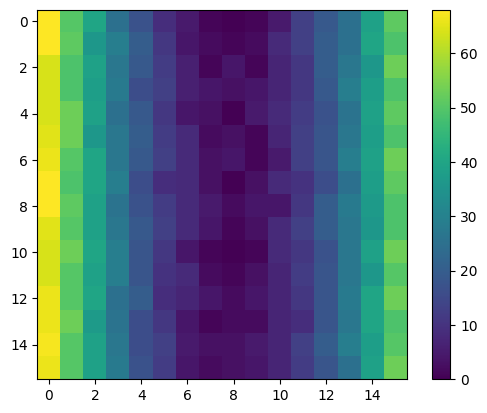

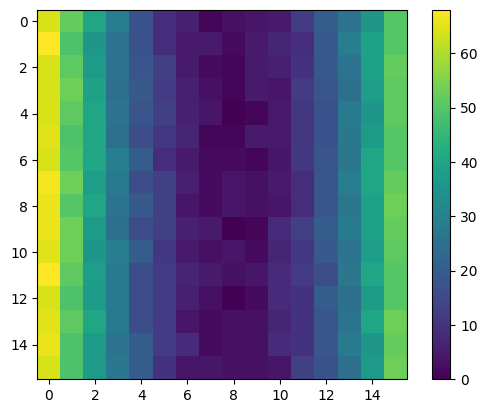

In [180]:
Xr = [[X[0][i][j] for j in range(N)] for i in range(N)]
Xi = [[X[1][i][j] for j in range(N)] for i in range(N)]

# Graficar la matriz
plt.imshow(Xr, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()

plt.imshow(Xi, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()

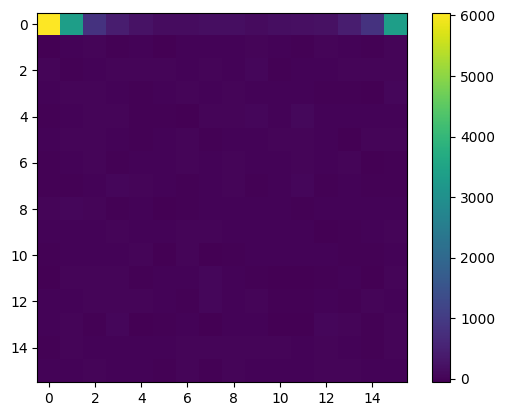

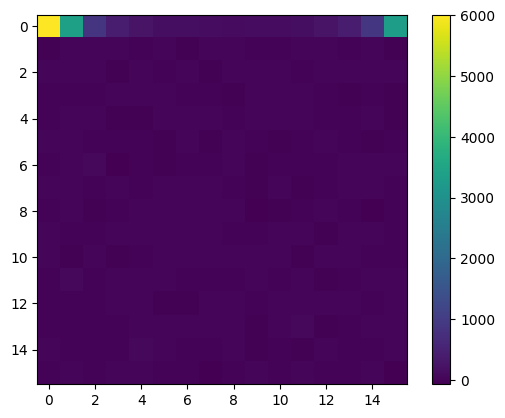

In [181]:
X1 = xfft2D(X, N)

X1r = [[X1[0][i][j] for j in range(N)] for i in range(N)]
X1i = [[X1[1][i][j] for j in range(N)] for i in range(N)]

# Graficar la matriz
plt.imshow(X1r, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()

plt.imshow(X1i, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()

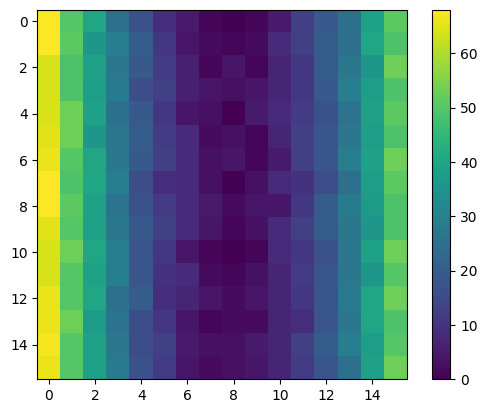

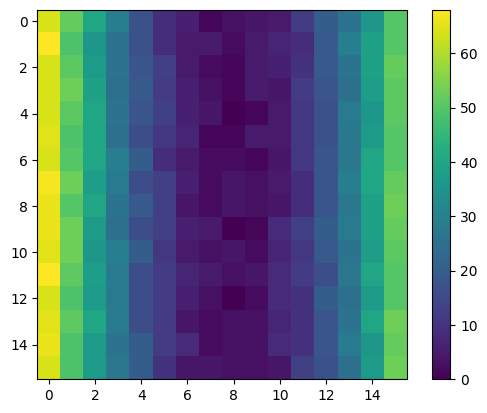

In [189]:
X2D = copy.deepcopy(X1)

for i in range(N):
    for j in range(N):
        X2D[0][i][j] = X2D[0][i][j] / (N**2)
        X2D[1][i][j] = X2D[1][i][j] / (N**2)
        
X2D = xifft2D(X2D, N)

X2Dr1 = [[X2D[0][i][j] for j in range(N)] for i in range(N)]
X2Di1 = [[X2D[1][i][j] for j in range(N)] for i in range(N)]

# Graficar la matriz
plt.imshow(X2Dr1, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()

plt.imshow(X2Di1, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Mostrar barra de color para la escala
plt.show()
        


## Code XTREME FFT

In [32]:
def varNameList(N):
    ls = []
    for i in range(N):
        name = "a" + str(i)
        ls.append(name)
    return ls

def xcfft2D(X, N):
    code = ""
    Xo = copy.deepcopy(X)
    n = int(log(N, 2))
    lvls = n + 1

    nodes = [2**(n - i) for i in range(0, n + 1)]
    values = [2**i for i in range(0, n + 1)]
    
    CoefR = [([cos(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]
    CoefI = [([-sin(2 * pi * v / values[lvl]) for v in range(values[lvl])]) for lvl in range(lvls)]

    index0 = []
    for i in range(N):
        idx = 0
        for j in range(n):
            idx += 2**j * ((i // (2 ** (n - 1 - j))) % 2)
        index0.append(idx)

    # blocks = [ 0 for j in range(N * 2 * 2)]     # (r, i) * (N * 2)
    blocks = varNameList(N * 2 * 2)
    
    for v in range(N * 2 * 2):
        code += f"{blocks[v]} = 0\n"

    # first pass
    for y in range(N):

        for i in range(N):
            code += f"{blocks[2 * i]} = Xo[0][{index0[i]}][{y}]\n"
            code += f"{blocks[2 * i + 1]} = Xo[1][{index0[i]}][{y}]\n"

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]}"
                    Ai = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]}"
            
                    Br = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]}"
                    Bi = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]}"
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                    
                    limit = 0.0000000001
                    
                    addP = True
                    A0r = f"{Ar} + ("
                    # real
                    if Cr < limit and Cr > -limit:
                        addP = False
                    elif Cr == 1:
                        A0r += f"{Br}"
                    elif Cr == -1:
                        A0r += f"-{Br}"
                    else:
                        A0r += f"{Br} * ({Cr:.10f})"
                        
                    if Ci < limit and Ci > -limit:
                        A0r += ")"
                    elif Ci == 1:
                        A0r += f" - {Bi})"
                    elif Ci == -1:
                        if addP:
                            A0r += f" + {Bi})"
                        else:
                            A0r += f"{Bi})"
                    else:
                        A0r += f" - {Bi} * ({Ci:.10f}))"
                        
                    addP = True
                    A0i = f"{Ai} + ("
                    if Ci < limit and Ci > -limit:
                        addP = False
                    elif Ci == 1:
                        A0i += f"{Br}"
                    elif Ci == -1:
                        A0i += f" -{Br}"
                    else:
                        A0i += f"{Br} * ({Ci:.10f})"
                        
                    if Cr < limit and Cr > -limit:
                        A0i += ")"
                    elif Cr == 1:
                        if addP:
                            A0i += f" + {Bi})"
                        else:
                            A0i += f"{Bi})"
                    elif Cr == -1:
                        A0i += f" -{Bi})"
                    else:
                        if addP:
                            A0i += f" + {Bi} * ({Cr:.10f}))"
                        else:
                            A0i += f"{Bi} * ({Cr:.10f}))"
                        
                        
                    Dr = f"{Ar} + ({Br} * ({Cr:.10f}) - {Bi} * ({Ci}))"
                    Di = f"{Ai} + ({Br} * ({Ci:.10f}) + {Bi} * ({Cr}))"
                
                    # code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)]} = {Dr}\n"
                    # code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1]} = {Di}\n"
                    
                    code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)]} = {A0r}\n"
                    code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1]} = {A0i}\n"
             
    
        for i in range(N):
            real = f"{blocks[(n % 2) * 2 * N + 2 * i]}"
            imag = f"{blocks[(n % 2) * 2 * N + 2 * i + 1]}"
            code += f"Xo[0][{i}][{y}] = {real}\n"
            code += f"Xo[1][{i}][{y}] = {imag}\n"
            
    # second pass
    for y in range(N):

        for i in range(N):
            code += f"{blocks[2 * i]} = Xo[0][{y}][{index0[i]}]\n"
            code += f"{blocks[2 * i + 1]} = Xo[1][{y}][{index0[i]}]\n"

        for lvl in range(1, n + 1):
            for nd in range(nodes[lvl]):
                for v in range(values[lvl]):
                    Ar = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1])]}"
                    Ai = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1]) + 1]}"
            
                    Br = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1])]}"
                    Bi = f"{blocks[((lvl + 1) % 2) * 2 * N + 2 * (values[lvl] * nd + v % values[lvl - 1] + values[lvl - 1]) + 1]}"
                
                    Cr = CoefR[lvl][v]
                    Ci = CoefI[lvl][v]
                
                    Dr = f"{Ar} + ({Br} * ({Cr:.10f}) - {Bi} * ({Ci:.10f}))"
                    Di = f"{Ai} + ({Br} * ({Ci:.10f}) + {Bi} * ({Cr:.10f}))"
                
                    code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v)]} = {Dr}\n"
                    code += f"{blocks[(lvl % 2) * 2 * N + 2 * (values[lvl] * nd + v) + 1]} = {Di}\n"
             
    
        for i in range(N):
            real = f"{blocks[(n % 2) * 2 * N + 2 * i]}"
            imag = f"{blocks[(n % 2) * 2 * N + 2 * i + 1]}"
            code += f"Xo[0][{y}][{i}] = {real}\n"
            code += f"Xo[1][{y}][{i}] = {imag}\n"
            
    return code

In [33]:
X = [randint(0, 10) for i in range(16)]
N = 16
print(xcfft2D(X, N))

a0 = 0
a1 = 0
a2 = 0
a3 = 0
a4 = 0
a5 = 0
a6 = 0
a7 = 0
a8 = 0
a9 = 0
a10 = 0
a11 = 0
a12 = 0
a13 = 0
a14 = 0
a15 = 0
a16 = 0
a17 = 0
a18 = 0
a19 = 0
a20 = 0
a21 = 0
a22 = 0
a23 = 0
a24 = 0
a25 = 0
a26 = 0
a27 = 0
a28 = 0
a29 = 0
a30 = 0
a31 = 0
a32 = 0
a33 = 0
a34 = 0
a35 = 0
a36 = 0
a37 = 0
a38 = 0
a39 = 0
a40 = 0
a41 = 0
a42 = 0
a43 = 0
a44 = 0
a45 = 0
a46 = 0
a47 = 0
a48 = 0
a49 = 0
a50 = 0
a51 = 0
a52 = 0
a53 = 0
a54 = 0
a55 = 0
a56 = 0
a57 = 0
a58 = 0
a59 = 0
a60 = 0
a61 = 0
a62 = 0
a63 = 0
a0 = Xo[0][0][0]
a1 = Xo[1][0][0]
a2 = Xo[0][8][0]
a3 = Xo[1][8][0]
a4 = Xo[0][4][0]
a5 = Xo[1][4][0]
a6 = Xo[0][12][0]
a7 = Xo[1][12][0]
a8 = Xo[0][2][0]
a9 = Xo[1][2][0]
a10 = Xo[0][10][0]
a11 = Xo[1][10][0]
a12 = Xo[0][6][0]
a13 = Xo[1][6][0]
a14 = Xo[0][14][0]
a15 = Xo[1][14][0]
a16 = Xo[0][1][0]
a17 = Xo[1][1][0]
a18 = Xo[0][9][0]
a19 = Xo[1][9][0]
a20 = Xo[0][5][0]
a21 = Xo[1][5][0]
a22 = Xo[0][13][0]
a23 = Xo[1][13][0]
a24 = Xo[0][3][0]
a25 = Xo[1][3][0]
a26 = Xo[0][11][0]
a27 = Xo[1][1